In [30]:
import pandas as pd
from pandas import Series, DataFrame
from pandas_datareader import DataReader
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
from scipy import stats
import time
from datetime import datetime, timedelta

import poloniex

sns.set_style('whitegrid')

In [2]:
polo = poloniex.Poloniex()
period = polo.DAY # period of data
end = time.time()
start = end - period * 365 # 1 year

coin_name_list = ['BTC', 'ETH', 'XRP']
coin_list = []

In [3]:
for coin in coin_name_list:
    print('USDT_%s'%coin)
    globals()[coin]  = DataFrame.from_dict(
                        polo.returnChartData('USDT_%s'%coin, period=period, start=start, end=end),
                        dtype=float)
    coin_list.append(globals()[coin])

USDT_BTC
USDT_ETH
USDT_XRP


In [4]:
timestamp = BTC['date'].values.tolist() # Series -> ndarray -> list
# timestamp -> year/month/day
date = [datetime.fromtimestamp(timestamp[i]).date() for i in range(len(timestamp))]

In [5]:
for COIN in coin_list:
    COIN.drop(['date', 'quoteVolume', 'weightedAverage'], axis=1, inplace=True)
    COIN.index = pd.to_datetime(date)
    COIN.index.name = 'Date'
    COIN.columns = ['High', 'Low', 'Open', 'Close', 'Volume']

In [6]:
def monte_carlo(start_price, days, dt, mu, sigma):
    prices = np.zeros(days)
    prices[0] = start_price
    
    shocks = np.zeros(days)
    drifts = np.zeros(days)
    
    for i in range(1, days):
        shocks[i] = np.random.normal(loc=0, scale=sigma*np.sqrt(dt))
        drifts[i] = mu * dt
        prices[i] = prices[i-1] + (prices[i-1] * (drifts[i] + shocks[i]))
        
    return prices

In [27]:
def simulateMonteCarlo(df, days, runs=5, kind='Open'):
    length = len(df) - days
    dt = 1 / days
    returns = df[kind].head(length).pct_change()
    mu = returns.mean()
    sigma = returns.std()
    
    simudf = DataFrame(df[kind])
    
    for run in range(runs):
        simu = np.full(len(df), None)
        simu[length:] = monte_carlo(df.iloc[length][kind], days, dt, mu, sigma)

        simudf['Simulate {}'.format(run+1)] = simu
    
    return simudf

In [120]:
def predictMonteCarlo(df, days, val_days, runs=5, kind='Open', eval_end=False):
    length = len(df) - val_days
    dt = 1 / days
    returns = df[kind].head(length).pct_change()
    mu = returns.mean()
    sigma = returns.std()
    
    simudf = DataFrame(df[kind])
    preddf = DataFrame(np.full(days, None), columns=[kind])
    preddf.index = pd.date_range(df.tail(1).index.values[0], periods=days+1, freq='D')[1:]
    simudf = pd.concat([simudf, preddf])
    
    # Simulate
    for run in range(1, runs+1):
        simu = np.full(len(df)+days, None)
        simu[length:] = monte_carlo(df.iloc[length][kind], val_days+days, dt, mu, sigma)

        simudf['Simulate {}'.format(run)] = simu
        
    # Evaluate
    score = []
    val = len(df) - 1
    goal = df[kind][val]
    for run in range(1, runs+1):
        if eval_end:
            score.append(abs(simudf['Simulate {}'.format(run)].iloc[val] - goal))
        else:
            score.append(np.mean(np.abs(simudf['Simulate {}'.format(run)].iloc[length:len(df)] - goal)))
    for run in range(1, runs+1):
        if run != np.argmin(score) + 1:
            simudf['Simulate {}'.format(run)].iloc[len(df):] = None
    print(score)
    return simudf

[464.75262772401254, 3528.8399924396945, 1981.2709171314139, 3895.576797990287, 4587.27873047347, 2416.088252145141, 1467.083693382966, 1884.8865244757023, 2020.092276868564, 1354.491134624827]


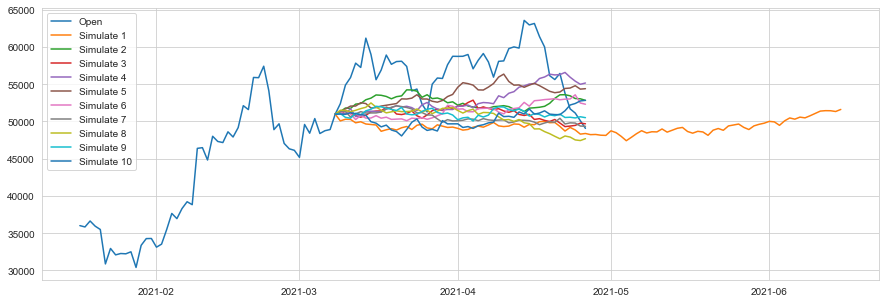

In [123]:
pred = predictMonteCarlo(BTC.tail(100), 50, 50, runs=10, eval_end=False)
plt.figure(figsize=(15, 5))
plt.plot(pred)
plt.legend(pred.columns)

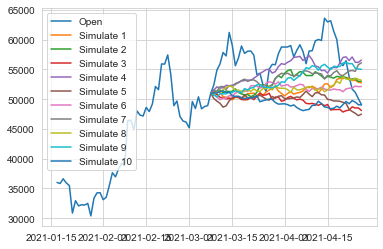

In [124]:
simulated = simulateMonteCarlo(BTC.tail(100), 50, runs=10)
plt.plot(simulated)
plt.legend(simulated.columns)

In [10]:
tech_name_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN'] #GAFA
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

tech_list = []

In [11]:
for stock in tech_name_list:
    tmp = DataReader(stock, 'yahoo', start, end)
    globals()[stock] = tmp.drop('Adj Close', axis=1)
    tech_list.append(globals()[stock])

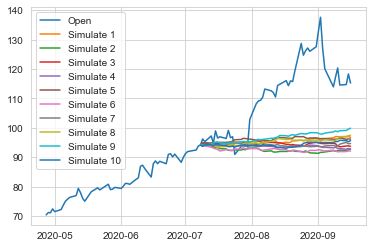

In [125]:
aapl_simu = simulateMonteCarlo(AAPL.head(100), 50, runs=10)
plt.plot(aapl_simu)
plt.legend(aapl_simu.columns)

[21.373107992322545, 21.70894425942191, 20.563742642605543, 19.085303431553783, 22.067949220854754, 20.88838084278965, 20.993050496840368, 20.860031938833057, 19.94922928266626, 19.205109277832115]


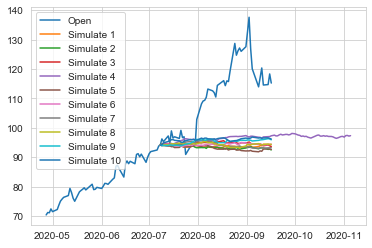

In [126]:
aapl_pred = predictMonteCarlo(AAPL.head(100), 50, 50, runs=10)
plt.plot(aapl_pred)
plt.legend(aapl_pred.columns)